 ### The following code implements  and compares advanced stochastic solvers  with and without learning rate schedulers ###
 
 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
import cProfile
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import torch
import torchvision
import torch.nn as nn
import pylops_gpu


from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy import misc
from tqdm.notebook import tqdm_notebook, tnrange
from torch.autograd import gradcheck
from pylops_gpu.utils.backend import device
from torch.nn import MSELoss
from torch.utils.data import Dataset, DataLoader

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.optimization.leastsquares  import *

In [2]:
###### Input parameters
par = {'ox':-300,  'dx':10,    'nx':61,
       'oy':-500,  'dy':10,    'ny':101,
       'ot':0,     'dt':0.004, 'nt':400,
       'f0': 20,   'nfmax': 200}

t0_m    = [0.2]
vrms_m  = [1100.]
amp_m   = [1.]

t0_G    = [0.2,0.5,0.7]
vrms_G  = [1200.,1500., 2000.]
amp_G   = [1.,0.6,0.5]

ns = par['ny']
nr = par['nx']
nt = par['nt']
nfmax = par['nfmax']
dr = par['dx']
ds = par['dy']
dt = par['dt']
f0 = par['f0']

# Create taper for operator
tap = taper3d(nt, (ns,nr), [5,5], tapertype='hanning')

# Create axis
t,t2,x,y = makeaxis(par)

# Create wavelet
wav = ricker(t[:41], f0)[0]

# Generate model
m, mwav = hyperbolic2d(x,t,t0_m,vrms_m,amp_m,wav)

# Generate operator
G,Gwavoriginal = np.zeros((ns,nr,nt)), - \
         np.zeros((ns,nr,nt))
for iy,y0 in enumerate(y):
    G[iy],Gwavoriginal[iy] = hyperbolic2d(x-y0,t,t0_G,vrms_G,amp_G,wav)
G,Gwavoriginal = G*tap,Gwavoriginal*tap



Gwav = Gwavoriginal
Gwavoriginal.shape

(101, 61, 400)

In [3]:
# Add negative part to operator and model
ns = Gwav.shape[0]
m     = np.concatenate((np.zeros((nr, nt-1)), m), axis=-1).T
mwav  = np.concatenate((np.zeros((nr, nt-1)), mwav), axis=-1).T
Gwav2 = np.concatenate((np.zeros((ns, nr, nt-1)), Gwav), axis=-1)

m.shape

(799, 61)

In [4]:
# Create frequency domain operator
Gwav_fft = np.fft.rfft(Gwav2, 2*nt-1, axis=-1)
Gwav_fft = Gwav_fft[...,:nfmax]
Gwav_fft = Gwav_fft.transpose(2,0,1)

# Create operator
MDCop=MDC(Gwav_fft, nt=2*nt-1, nv=1, dt=dt, dr=dr, 
          twosided=True, transpose=False)
dottest(MDCop, MDCop.shape[0], MDCop.shape[1], complexflag=3, verb=True)

# Create data
d = MDCop*m.flatten()
d = d.reshape(2*nt-1, ns)


MDCop.shape

Dot test passed, v^T(Opu)=-1444.366818-2969.832538i - u^T(Op^Tv)=-1444.366818+3674.273863i


(80699, 48739)

In [5]:

MDCop = pylops_gpu.TorchOperator(MDCop, pylops = True)
d =  torch.from_numpy(d.astype(np.float32))
m  =  torch.from_numpy(m.astype(np.float32))
Gwav2 = torch.from_numpy(Gwav2.astype(np.float32))

d1 = MDCop.apply(m.flatten())
d1 = d1.view(2*nt-1, ns)

In [6]:
nv=1
class GwavSGD(nn.Module):
  def __init__(self,nt,nv,dt,dr,ns):
    self.nt = nt
    self.nv = nv
    self.dt = dt
    self.dr =dr
    self.ns = ns
    super().__init__()


  def forward(self,model, Gwav_fft):
    
    MDCop=MDC(Gwav_fft, nt=2*self.nt-1, nv=self.nv, dt=self.dt, dr=self.dr, 
          twosided=True, transpose=False)
    
    MDCop = pylops_gpu.TorchOperator(MDCop, pylops = True)
    
    data = MDCop.apply(model.flatten())
    data = data.view(2*self.nt-1, self.ns)
 

    return data


In [7]:
lossdict = {}
avgdict = {}

In [8]:
def advoptMDD(model, optimizer, lr):
  if optimizer == 'SGD':
 
      optimizer = torch.optim.SGD([model], lr = lr, weight_decay =0, momentum=0.9, dampening=0, nesterov=True)
  
  elif optimizer == 'ASGD':
    
     optimizer = torch.optim.ASGD([model], lr=lr)

  elif optimizer == 'Adadelta':
   
      optimizer = torch.optim.Adadelta([model], lr =lr, rho =0.9,weight_decay=0)
 

  elif optimizer == 'Adam':
   
      optimizer= torch.optim.Adam([model], lr=lr, eps =1e-8)
   
  elif optimizer == 'RMSprop':
   
      optimizer= torch.optim.RMSprop([model], lr =lr, centered=True, alpha=0.9)
    

  elif optimizer == 'Adagrad':
    
      optimizer= torch.optim.Adagrad([model], lr = lr, eps = 1e-10, lr_decay =0)
  

  return optimizer



  


In [9]:

def advancedSolvers(GwavSGD,model, optimizer, lr, n_epochs):
  criterion = nn.MSELoss()
  optimizer = advoptMDD(model, optimizer, lr)
 

  GwavTorch = GwavSGD(nt,nv,dt,dr,ns)
  lossHist=[]
  lossavg=[]
  for epoch in range(n_epochs):
    data = GwavTorch(model,Gwav_fft)
    lost = criterion(d1, data)
    loss = (1/Gwav2.shape[0]) * lost
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    
    
    lossHist.append(loss.item())
   
    avg = sum(lossHist) / len(lossHist)
    lossavg.append(avg)
    
    
    if (epoch+1) %10 ==0:
     print(f'epoch: {epoch+1}, loss : {loss.item():.4f}, loss avg : {avg:.4f}')
  

    lossdict[optimizer] = lossHist
    avgdict[optimizer] = lossavg

  return lossHist, lossavg

In [10]:
# This solvers performs best for Adam, Adagrad, RMSprop at low lr

model = np.zeros((m.shape[0], m.shape[1]))
model = torch.from_numpy(model)
model.requires_grad= True


solver = advancedSolvers(GwavSGD,model,'RMSprop', lr =0.01, n_epochs=100)

epoch: 10, loss : 0.0038, loss avg : 0.0241
epoch: 20, loss : 0.0025, loss avg : 0.0166
epoch: 30, loss : 0.0083, loss avg : 0.0140
epoch: 40, loss : 0.0054, loss avg : 0.0125
epoch: 50, loss : 0.0088, loss avg : 0.0117
epoch: 60, loss : 0.0071, loss avg : 0.0111
epoch: 70, loss : 0.0086, loss avg : 0.0107
epoch: 80, loss : 0.0078, loss avg : 0.0104
epoch: 90, loss : 0.0084, loss avg : 0.0102
epoch: 100, loss : 0.0080, loss avg : 0.0100


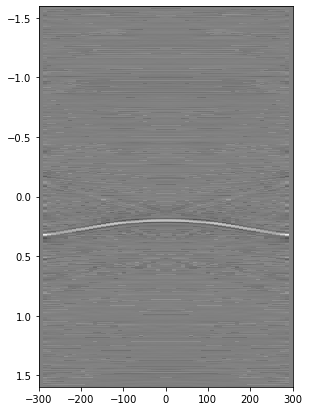

In [11]:
fig = plt.figure(figsize= (12,7))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax1.imshow(model.detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-model.detach().numpy().max(), vmax=model.detach().numpy().max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))

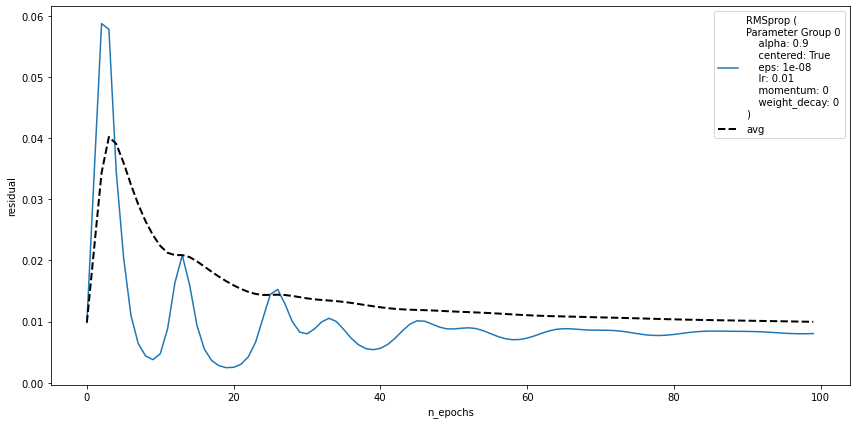

In [12]:

for loss, avg in zip(lossdict.keys(), avgdict.keys()):
  fig = plt.figure(figsize= (12,6))
  plt.plot(lossdict[loss], label = loss)
  plt.plot(avgdict[avg], 'k--',label = "avg", linewidth = 2)
  plt.xlabel('n_epochs')
  plt.ylabel('residual')
  plt.legend()
  plt.tight_layout()



**Advanced solvers with lr_schedulers**

This performs best for SGD and Adadelta solvers.

In [13]:
lossdict_schedule= {}
avgdict_schedule = {}


def advancedSolversSche(GwavSGD,model, optimizer, lr, n_epochs):
  criterion = nn.MSELoss()
  optimizer = advoptMDD(model, optimizer, lr)
  scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda =[lambda1], last_epoch=-1, verbose=False)
  scheduler1 = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.1, last_epoch=-1, verbose=False)
  # print(scheduler1.get_last_lr())

  GwavTorch = GwavSGD(nt,nv,dt,dr,ns)
  lossHistt=[]
  lossavgg=[]

  for epoch in range(n_epochs):
    data = GwavTorch(model,Gwav_fft)
    lost = criterion(d1, data)
    loss = (1/Gwav2.shape[0]) * lost
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    scheduler.step()
    scheduler1.step()
    # print(scheduler1.get_last_lr())
    
    lossHistt.append(loss.item())
   
    avg = sum(lossHistt) / len(lossHistt)
    lossavgg.append(avg)
    
    
    if (epoch+1) %10 ==0:
     print(f'epoch: {epoch+1}, loss : {loss.item():.4f}, loss avg : {avg:.4f}')
  

    lossdict_schedule[optimizer] = lossHistt
    avgdict_schedule[optimizer] = lossavgg

  return lossHistt, lossavgg

In [14]:

model = np.zeros((m.shape[0], m.shape[1]))
model = torch.from_numpy(model)
model.requires_grad= True

lambda1 = lambda epoch: epoch // 0.1

solver = advancedSolversSche(GwavSGD,model,'SGD', lr =1, n_epochs=100)


epoch: 10, loss : 0.0032, loss avg : 0.0071
epoch: 20, loss : 0.0014, loss avg : 0.0045
epoch: 30, loss : 0.0004, loss avg : 0.0033
epoch: 40, loss : 0.0001, loss avg : 0.0025
epoch: 50, loss : 0.0000, loss avg : 0.0020
epoch: 60, loss : 0.0000, loss avg : 0.0017
epoch: 70, loss : 0.0000, loss avg : 0.0014
epoch: 80, loss : 0.0000, loss avg : 0.0013
epoch: 90, loss : 0.0000, loss avg : 0.0011
epoch: 100, loss : 0.0000, loss avg : 0.0010


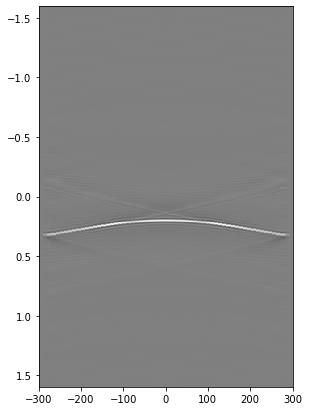

In [15]:
fig = plt.figure(figsize= (12,7))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax1.imshow(model.detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-model.detach().numpy().max(), vmax=model.detach().numpy().max(),
           extent=(x.min(),x.max(),t2.max(),t2.min()))

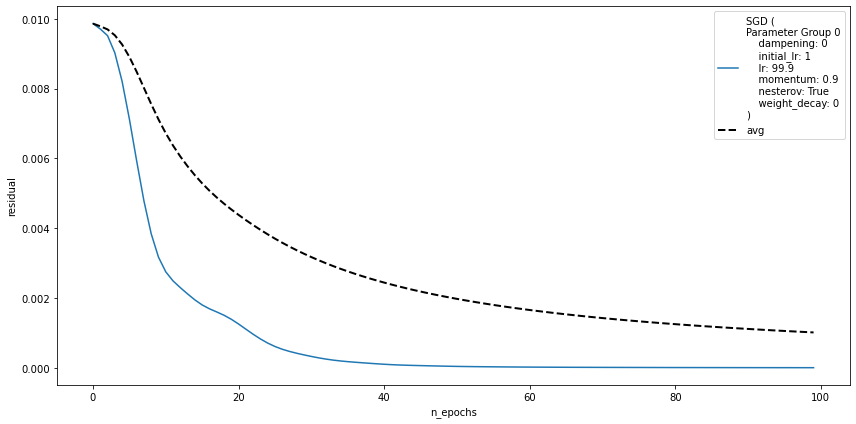

In [16]:
for sch_loss, sch_avg in zip(lossdict_schedule.keys(), avgdict_schedule.keys()):
  fig = plt.figure(figsize= (12,6))
  plt.plot(lossdict_schedule[sch_loss], label = sch_loss)
  plt.plot(avgdict_schedule[sch_avg], 'k--',label = "avg", linewidth = 2)
  plt.xlabel('n_epochs')
  plt.ylabel('residual')
  plt.legend()
  plt.tight_layout()